In [2]:
# # Import standard libraries
import os
import csv
import json
import re
import random
import pandas as pd
from datetime import datetime
import requests # For making HTTP requests to APIs
from dotenv import load_dotenv
import torch # PyTorch library, used for working with tensors and training deep learning models
import math
import matplotlib.pyplot as plt

# Import OpenAI API to use OpenAI services
import openai
from openai import OpenAI

# Scikit-learn for splitting data into training and testing sets
from sklearn.model_selection import train_test_split

# Datasets library for loading datasets and working with Hugging Face's datasets
from datasets import load_dataset, Dataset

# Hugging Face Transformers library for handling tokenization, models, and training processes
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForLanguageModeling, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq




# Gather data from Crunchbase Basic API 

In [3]:
#Load crunchbase api
load_dotenv()
cb_api_key = os.getenv("CB_API")

In [6]:
# API endpoint for searching organizations in Crunchbase
url = 'https://api.crunchbase.com/v4/data/searches/organizations'

# Headers including the API key for authentication
headers = {
    'Content-Type': 'application/json',
    'X-CB-USER-KEY': cb_api_key
}

# Request body defining the fields to retrieve and limiting to 100 result
body = {
    "field_ids": [
        "identifier", "name", "short_description", 
        "location_identifiers", "created_at", "facet_ids"
    ],
    "limit": 1000 # Maximum number allowed by the API
}

# Make a POST request to the API with the provided body and headers
response = requests.post(url, headers=headers, json=body)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    data = response.json()
else:
    print(f"Error fetching data: {response.status_code} - {response.text}")


In [7]:
# Extract relevant information into a list of dictionaries
results = []
for organization in data.get("entities", []):
     # Extract location name (city)
        location_data = organization.get("properties", {}).get("location_identifiers", [])
        city_name = location_data[0].get("value", "") if location_data else ""

 # Extract the year from created_at field
        created_at = organization.get("properties", {}).get("created_at", "")
        created_year = datetime.strptime(created_at, "%Y-%m-%dT%H:%M:%SZ").year if created_at else ""

   # Append extracted data to results
        results.append({
            "identifier": organization.get("identifier", {}).get("uuid", ""),
            "name": organization.get("properties", {}).get("name", ""),
            "short_description": organization.get("properties", {}).get("short_description", ""),
            "location": city_name,  # Only the city name
            "created_year": created_year  # Extracted year from created_at

        })
        
# Create a DataFrame from the list of dictionaries
crunchbase_df = pd.DataFrame(results)

# Print the first few rows of the DataFrame to inspect the data
crunchbase_df.head()

,identifier,name,short_description,location,created_year
0,,Citi,Citigroup is a financial services holding comp...,New York,2007
1,,UBS,UBS is a global financial services company tha...,Zürich,2009
2,,Amazon,Amazon is a global tech firm with a focus on e...,Seattle,2014
3,,Ola Electric,Ola Electric focuses on developing and manufac...,Bengaluru,2019
4,,Groq,Groq radically simplifies compute to accelerat...,Mountain View,2017


In [33]:
# Create new df filtered for "mental health" out of curiosity to show skills in data filtering
health_df = crunchbase_df[crunchbase_df['short_description'].str.contains(" mental health", case=False, na=False)]

# Display the filtered DataFrame
health_df.head()


,identifier,name,short_description,location,created_year
328,,Headspace,Headspace specializes in providing mental heal...,Santa Monica,2013
456,,Vitable Health,Vitable Health offers primary care and mental ...,Philadelphia,2020
463,,Talkiatry,Talkiatry provides virtual mental healthcare c...,New York,2021
635,,Rula,Rula is a leading company in the behavioral he...,Los Angeles,2019
689,,Clare&me,Clare&me is an AI-powered mental health coach ...,Berlin,2021


In [34]:
#save the data to a csv file
crunchbase_df.to_csv("crunchbase_data.csv", index=False)
csv_file = 'crunchbase_data.csv'

# Train Hugging Face Model on Crunchbase Basic API Data 
Round 1 of Training: here we train the model on the Crunchbase data to help it learn startup knowledge.

In [37]:
# Convert the DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(crunchbase_df)

# Display dataset
dataset = dataset.remove_columns("identifier")  # Clean up unnecessary index column
print(dataset)

# Prepare input-output format for the training
def preprocess_function(examples):
    inputs = []
    targets = []
    for i in range(len(examples['name'])):
        # Use the name as input
        input_text = f"Company: {examples['name'][i]}"
        
        # Combine multiple fields for target
        target_text = f"Location: {examples['location'][i]} | Description: {examples['short_description'][i]} | Year: {examples['created_year'][i]}"
        
        inputs.append(input_text)
        targets.append(target_text)
        
    return {'input_text': inputs, 'target_text': targets}

# Apply the preprocess function to the dataset 
dataset = dataset.map(preprocess_function, batched=True)
dataset = dataset.train_test_split(test_size=0.2)


Dataset({
    features: ['name', 'short_description', 'location', 'created_year'],
    num_rows: 1000
})


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [38]:
#Initialize the model and tokenizer
model_name = "t5-small" #T5 transformer model is great for text-to-text tasks
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Tokenize dataset
def tokenize_function(examples):
    inputs = tokenizer(examples['input_text'], truncation=True, padding='max_length', max_length=512)
    targets = tokenizer(examples['target_text'], truncation=True, padding='max_length', max_length=128)
    inputs['labels'] = targets['input_ids']
    return inputs

tokenized_datasets = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [42]:
# Move model to GPU for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# I selected Seq2SeqTrainingArguments because it is specifically designed for training sequence-to-sequence models like T5
# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16, # 16 was chosen as a moderate batch size
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
)

# Trainer setup
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
)

# Train the model
trainer.train()


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.6975992918014526, 'eval_runtime': 7.5069, 'eval_samples_per_second': 26.642, 'eval_steps_per_second': 1.732, 'epoch': 1.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.4570027589797974, 'eval_runtime': 14.4039, 'eval_samples_per_second': 13.885, 'eval_steps_per_second': 0.903, 'epoch': 2.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.379213809967041, 'eval_runtime': 12.4647, 'eval_samples_per_second': 16.045, 'eval_steps_per_second': 1.043, 'epoch': 3.0}
{'train_runtime': 973.5532, 'train_samples_per_second': 2.465, 'train_steps_per_second': 0.154, 'train_loss': 3.6434130859375, 'epoch': 3.0}


TrainOutput(global_step=150, training_loss=3.6434130859375, metrics={'train_runtime': 973.5532, 'train_samples_per_second': 2.465, 'train_steps_per_second': 0.154, 'total_flos': 324820323532800.0, 'train_loss': 3.6434130859375, 'epoch': 3.0})

In [47]:
# Evaluate the model on the test dataset
results = trainer.evaluate()

# Calculate the perplexity score from the evaluation results
if "eval_loss" in results:
    perplexity = math.exp(results["eval_loss"])
    results["perplexity"] = perplexity


# Convert the results into a list of dictionaries for the DataFrame
evaluation_results = [{"Metric": key.replace('_', ' ').capitalize(), "Value": round(value, 4)} for key, value in results.items()]

# Create a DataFrame from the list of dictionaries
df_results = pd.DataFrame(evaluation_results)

# Set the index for better readability
df_results.set_index("Metric", inplace=True)

# Display the DataFrame with perplexity
df_results

  0%|          | 0/13 [00:00<?, ?it/s]

,Value
Metric,
Eval loss,1.3792
Eval runtime,7.6481
Eval samples per second,26.1500
Eval steps per second,1.7000
Epoch,3.0000
Perplexity,3.9718


In [118]:
# Save the results to a list to compare all results 
results_list_all = [evaluation_results[0], evaluation_results[5]]

# change name of the metrics to say HuggingFace 
results_list_all[0]['Metric'] = 'Training Loss CB data Trained T5'
results_list_all[1]['Metric'] = 'Perplexity CB data Trained T5'

results_list_all

[{'Metric': 'Training Loss CB data Trained T5', 'Value': 1.3792},
 {'Metric': 'Perplexity CB data Trained T5', 'Value': 3.9718}]

In [49]:
# Save the trained model and tokenizer
trainer.save_model("crunchbase_trained_model")
tokenizer.save_pretrained("crunchbase_trained_model")

('crunchbase_trained_model/tokenizer_config.json',
 'crunchbase_trained_model/special_tokens_map.json',
 'crunchbase_trained_model/spiece.model',
 'crunchbase_trained_model/added_tokens.json')

# Prompt Engineering

To fine tune the T5 model created, we used the crunchbase data to generate pairs of prompts and completions and then export these pairs as JSON lines into an output file. We will also fine tune a Chat GPT model with these prompts. 

In [8]:
#function to replace newlines with spaces and remove any leading/trailing whitespace
def replace_newlines_with_spaces(text):
    return text.replace("\n", " ").strip()

# Function to generate prompt-completion pairs based on Crunchbase data
def generate_prompt_completion_pairs(input_csv_file, output_jsonl_file):
    prompt_completion_pairs = []

    with open(input_csv_file, 'r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            # First prompt-completion pair: Generate a prompt asking for a summary of the startup
            prompt = f"""
                Please provide a summary of the startup {row['name']}.
            """
            # Generate a completion based on startup details such as founded year, location, and short description
            completion = (
                f"{row['name']} was founded in {row['created_year']} and is based in {row['location']}. "
                f"It focuses on {row['short_description']}."
            )

            # Clean up the prompt and completion 
            prompt = replace_newlines_with_spaces(prompt)
            completion = replace_newlines_with_spaces(completion)

            # Append the formatted prompt-completion pair to the list using OpenAI fine-tuning format
            prompt_completion_pairs.append({
                "messages": [
                    {"role": "user", "content": prompt},
                    {"role": "assistant", "content": completion}
                ]
            })

            # Additional prompt-completion pair examples: Asking specific details about the startup's founding year and location
            prompt = f"What year was {row['name']} founded, and where is it located?"
            completion = f"{row['name']} was founded in {row['created_year']} and is located in {row['location']}."

            # Clean up the prompt and completion
            prompt = replace_newlines_with_spaces(prompt)
            completion = replace_newlines_with_spaces(completion)

            # Append this second prompt-completion pair to the list
            prompt_completion_pairs.append({
                "messages": [
                    {"role": "user", "content": prompt},
                    {"role": "assistant", "content": completion}
                ]
            })

    # Export the pairs to a JSONL file (each pair is written as a separate line)
    with open(output_jsonl_file, 'w') as jsonl_file:
        for pair in prompt_completion_pairs:
            json.dump(pair, jsonl_file)
            jsonl_file.write('\n')

    # Print a message indicating how many pairs were generated and the location of the output file
    print(f"Generated {len(prompt_completion_pairs)} prompt-completion pairs and exported to {output_jsonl_file}")

# usage of the function: generate prompt-completion pairs from 'crunchbase_data.csv' and save to 'output_prompts_completions.jsonl'
generate_prompt_completion_pairs('crunchbase_data.csv', 'output_prompts_completions.jsonl')

Generated 2000 prompt-completion pairs and exported to output_prompts_completions.jsonl


## Train Test Split Prompt Completion Startup Data 

In [51]:
#Load prompt-completion pairs from the JSONL file
def load_data(jsonl_file):
    data = []
    # Open the JSONL file for reading
    with open(jsonl_file, 'r') as f:
        # Loop through each line in the file
        for line in f:
            # Parse each line as a JSON object and append it to the data list
            data.append(json.loads(line))
    return data

data = load_data('output_prompts_completions.jsonl')

# Prepare Data for Training and Testing
def prepare_data(data):
    # Shuffle data to randomize the order
    random.shuffle(data)
    
    # Split data into 80% training, 20% testing
    train_size = int(0.8 * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    return train_data, test_data

# train and test data format for openai fine-tuning
train_data, test_data = prepare_data(data)

# Fine Tuning Using HuggingFace Transformers 

Round 2 of Training: We are fine-tuning the T5 Model we just trained on the crunchbase data. Here I used the prompt-completion dataset to fine-tune the model to help the model's language generation abilities, making it more conversational and better at generating relevant completions.

In [55]:
# Convert to HuggingFace dataset format
def convert_to_dataset(data):
    prompts = []
    completions = []
    for pair in data:
        prompt = pair['messages'][0]['content']
        completion = pair['messages'][1]['content']
        prompts.append(prompt)
        completions.append(completion)
    
    dataset = Dataset.from_dict({"prompt": prompts, "completion": completions})
    return dataset

train_dataset = convert_to_dataset(train_data)
test_dataset = convert_to_dataset(test_data)

In [56]:
# Load the pre-trained on crunchbase data T5 model and tokenizer
model_name = "/Users/priscillamorales/Desktop/CodeSpace/Personal_Projects/Crunchbase_Project/crunchbase_trained_model" 
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Tokenize the data for prompt-completion fine-tuning
def tokenize_function(examples):
    inputs = tokenizer(examples["prompt"], padding="longest", truncation=True)
    targets = tokenizer(examples["completion"], padding="longest", truncation=True)
    
    # Adjust the inputs to include the labels (target token IDs) for the decoder
    # These labels will be used by the model for generating output during training
    inputs["labels"] = targets["input_ids"]
    return inputs

# Apply the tokenization function to the training and testing dataset to convert the "prompt" and "completion" fields into tokenized format
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["prompt", "completion"])
test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=["prompt", "completion"])

# Set up Training Arguments, 3 epochs were selected to balance sufficient training time without overfitting. 
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8, 
    per_device_eval_batch_size=8, #Fine-tuning requires more precision, hence a smaller batch size of 8 was chosen
    num_train_epochs=3,
    save_steps=500,
    save_total_limit=2,
    logging_dir='./logs',
    predict_with_generate=True,  # Important for text generation
)

# Data Collator for Seq2Seq Tasks
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Trainer Setup
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
)

# Train the Model
trainer.train()

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.7456273436546326, 'eval_runtime': 1.9927, 'eval_samples_per_second': 200.729, 'eval_steps_per_second': 25.091, 'epoch': 1.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.7241692543029785, 'eval_runtime': 1.3425, 'eval_samples_per_second': 297.946, 'eval_steps_per_second': 37.243, 'epoch': 2.0}
{'loss': 0.9368, 'grad_norm': 0.7895172238349915, 'learning_rate': 8.333333333333334e-06, 'epoch': 2.5}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.72039395570755, 'eval_runtime': 1.6214, 'eval_samples_per_second': 246.694, 'eval_steps_per_second': 30.837, 'epoch': 3.0}
{'train_runtime': 92.2244, 'train_samples_per_second': 52.047, 'train_steps_per_second': 6.506, 'train_loss': 0.89914431254069, 'epoch': 3.0}


TrainOutput(global_step=600, training_loss=0.89914431254069, metrics={'train_runtime': 92.2244, 'train_samples_per_second': 52.047, 'train_steps_per_second': 6.506, 'total_flos': 32943040364544.0, 'train_loss': 0.89914431254069, 'epoch': 3.0})

In [59]:
# Step 6: Evaluate the Model
results = trainer.evaluate()

# Calculate perplexity from the evaluation loss
if "eval_loss" in results:
    perplexity = math.exp(results["eval_loss"])
    results["perplexity"] = perplexity

# Convert the results into a list of dictionaries for the DataFrame
results_list = [{"Metric": key.replace('_', ' ').capitalize(), "Value": round(value, 4)} for key, value in results.items()]

# Create a DataFrame from the list of dictionaries
df_results = pd.DataFrame(results_list)

# Set the index for better readability
df_results.set_index("Metric", inplace=True)

# Display the DataFrame with perplexity
df_results

  0%|          | 0/50 [00:00<?, ?it/s]

,Value
Metric,
Eval loss,0.7204
Eval runtime,2.7632
Eval samples per second,144.7610
Eval steps per second,18.0950
Epoch,3.0000
Perplexity,2.0552


In [119]:
# Append new metrics to results_list_all
results_list_all.append(results_list[0])
results_list_all.append(results_list[5])

# change name of the metrics 
results_list_all[2]['Metric'] = 'Training Loss CB Fine-Tuned T5'
results_list_all[3]['Metric'] = 'Perplexity CB Fine-Tuned T5'

results_list_all

[{'Metric': 'Training Loss CB data Trained T5', 'Value': 1.3792},
 {'Metric': 'Perplexity CB data Trained T5', 'Value': 3.9718},
 {'Metric': 'Training Loss CB Fine-Tuned T5', 'Value': 0.7204},
 {'Metric': 'Perplexity CB Fine-Tuned T5', 'Value': 2.0552}]

In [68]:
trainer.save_model("fine_tuned_prompt_completion_model")
tokenizer.save_pretrained("fine_tuned_prompt_completion_model")

('fine_tuned_prompt_completion_model/tokenizer_config.json',
 'fine_tuned_prompt_completion_model/special_tokens_map.json',
 'fine_tuned_prompt_completion_model/spiece.model',
 'fine_tuned_prompt_completion_model/added_tokens.json')

## Gradio App to interact with Model

In [86]:
# Import Gradio
import gradio as gr
from transformers import pipeline

In [90]:
model = "path"

# Initialize the pipeline to generate
model_pipeline = pipeline("text2text-generation", model=model)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [91]:
def predict(input_text):
    # Use pipeline to generate a response
    output = model_pipeline(input_text, max_length=100, num_beams=5, early_stopping=True)
    return output[0]['generated_text']

In [92]:
# Create Gradio interface
interface = gr.Interface(fn=predict, inputs="text", outputs="text", title="Interact with Fine-tuned T5 Model")

# Launch the app.
interface.launch(show_error=True)

Running on local URL:  http://127.0.0.1:7868

To create a public link, set `share=True` in `launch()`.


**Testing the Gradio interaction with model results**: The model is running well, however, input must be similar or exactly match prompt question it was trained on. If prompt varies in language used, the output wasn't as expected. 

# Fine Tuning From Open AI Assistants API

In [ ]:
# Load API keys from .env file
load_dotenv()
open_ai_key = os.getenv("OPENAI_API_KEY")
client = OpenAI()

# Select GPT model 
GPT_MODEL = "gpt-3.5-turbo"

In [70]:
# Function to convert dataset to JSONL format for OpenAI fine-tuning
def convert_to_jsonl(data, output_file):
    with open(output_file, 'w') as jsonl_file:
        for data_point in data:
            # Write each data point to a JSONL file
            json.dump(data_point, jsonl_file)
            jsonl_file.write('\n')

# Convert train data to JSONL
convert_to_jsonl(train_data, 'train_dataset_openai.jsonl')

# Convert test data to JSONL
convert_to_jsonl(test_data, 'test_dataset_openai.jsonl')

print("Conversion to JSONL format complete!")

Conversion to JSONL format complete!


In [82]:
#Upload training data to OpenAI
file_train = client.files.create(
  file = open('train_dataset_openai.jsonl', "rb"),
  purpose = 'fine-tune'
)

file_train

#Save train file_id to variable
train_file_id = file_train.id

FileObject(id='file-8tgZuKIWvuea3SEYLCppQxxB', bytes=414187, created_at=1723994904, filename='train_dataset_openai.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [84]:
#Upload testing data to OpenAI
file_test = client.files.create(
  file=open('test_dataset_openai.jsonl', "rb"),
  purpose='fine-tune'
)

file_test

#Save test file_id to variable
file_test_id = file_test.id

FileObject(id='file-9S9Re5NPdF3zNn73GSBzCLNk', bytes=105008, created_at=1723994910, filename='test_dataset_openai.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
#Create fine-tuning job in OpenAI
fine_tuning_job = client.fine_tuning.jobs.create(
    model = "gpt-3.5-turbo", 
    training_file = train_file_id,
    validation_file = file_test_id,
    suffix = "crunchbase data"
)
fine_tuning_job

In [95]:
#Re - run this cell until the fine-tuning job is complete
fine_tuning_events = client.fine_tuning.jobs.list_events(fine_tuning_job_id='ftjob-k0WCsMZyRBxCgpP1raG8P1z3', limit=10)

for event in fine_tuning_events.data:
    print(event.message)

python(11798) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


The job has successfully completed
New fine-tuned model created: ft:gpt-3.5-turbo-0125:personal:crunchbase-data:9xczAAsN
Checkpoint created at step 1599 with Snapshot ID: ft:gpt-3.5-turbo-0125:personal:crunchbase-data:9xczAZr4:ckpt-step-1599
Checkpoint created at step 1066 with Snapshot ID: ft:gpt-3.5-turbo-0125:personal:crunchbase-data:9xczAdot:ckpt-step-1066
Step 1600/1600: training loss=0.68, validation loss=0.79
Step 1599/1600: training loss=0.49, full validation loss=0.68
Step 1598/1600: training loss=0.64
Step 1597/1600: training loss=0.39
Step 1596/1600: training loss=0.30
Step 1595/1600: training loss=0.38


In [112]:
# Retrieve the fine-tuning job, noted the value for fine_tuned_model to interact with model in the next cell
client.fine_tuning.jobs.retrieve("ftjob-k0WCsMZyRBxCgpP1raG8P1z3")


FineTuningJob(id='ftjob-k0WCsMZyRBxCgpP1raG8P1z3', created_at=1723994916, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal:crunchbase-data:9xczAAsN', finished_at=1723998239, hyperparameters=Hyperparameters(n_epochs=3, batch_size=3, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-ADSRmNPyEVkr78tS48iT4Xkl', result_files=['file-be1SEpnk0fLU0OeKWhBQawSu'], seed=1746319074, status='succeeded', trained_tokens=227277, training_file='file-8tgZuKIWvuea3SEYLCppQxxB', validation_file='file-9S9Re5NPdF3zNn73GSBzCLNk', estimated_finish=None, integrations=[], user_provided_suffix='crunchbase data')

Fine-tuning with openai took approximately 35 minutes at which point I received an email from openai that fine tuning job was successfully completed. 

Next we evaluate model fine tuned with Open AI 

In [96]:
# Get metrics for fine tuning job 
fine_tuning_events = client.fine_tuning.jobs.list_events("ftjob-k0WCsMZyRBxCgpP1raG8P1z3")
# List to store all metrics
metrics_list = []

# Loop through fine_tuning_events and collect data dictionaries
for event in fine_tuning_events.data:
    metrics = event.data
    
    # If metrics is not empty, add it to the list
    if metrics:
        metrics_list.append(metrics)

# Define expected keys
all_keys = ['step', 'train_loss', 'valid_loss', 'total_steps', 'train_mean_token_accuracy', 'valid_mean_token_accuracy', 'full_valid_loss']

# Ensure all dictionaries have the same keys
for metric in metrics_list:
    for key in all_keys:
        if key not in metric:
            metric[key] = None

# Create DataFrame from the list of metrics
metrics_df = pd.DataFrame(metrics_list)


# Display the DataFrame
metrics_df


,step,train_loss,valid_loss,total_steps,train_mean_token_accuracy,valid_mean_token_accuracy,full_valid_loss,full_valid_mean_token_accuracy
0,1600,0.682561,0.792585,1600,0.848101,0.826531,NaN,NaN
1,1599,0.489184,NaN,1600,0.884058,NaN,0.677292,0.838886
2,1598,0.642393,NaN,1600,0.858586,NaN,NaN,NaN
3,1597,0.394121,NaN,1600,0.896226,NaN,NaN,NaN
4,1596,0.299830,NaN,1600,0.927083,NaN,NaN,NaN
5,1595,0.375489,NaN,1600,0.910448,NaN,NaN,NaN
6,1594,0.529038,NaN,1600,0.863636,NaN,NaN,NaN
7,1593,0.124619,NaN,1600,0.925926,NaN,NaN,NaN
8,1592,0.179901,NaN,1600,0.960000,NaN,NaN,NaN
9,1591,0.187091,NaN,1600,0.959184,NaN,NaN,NaN


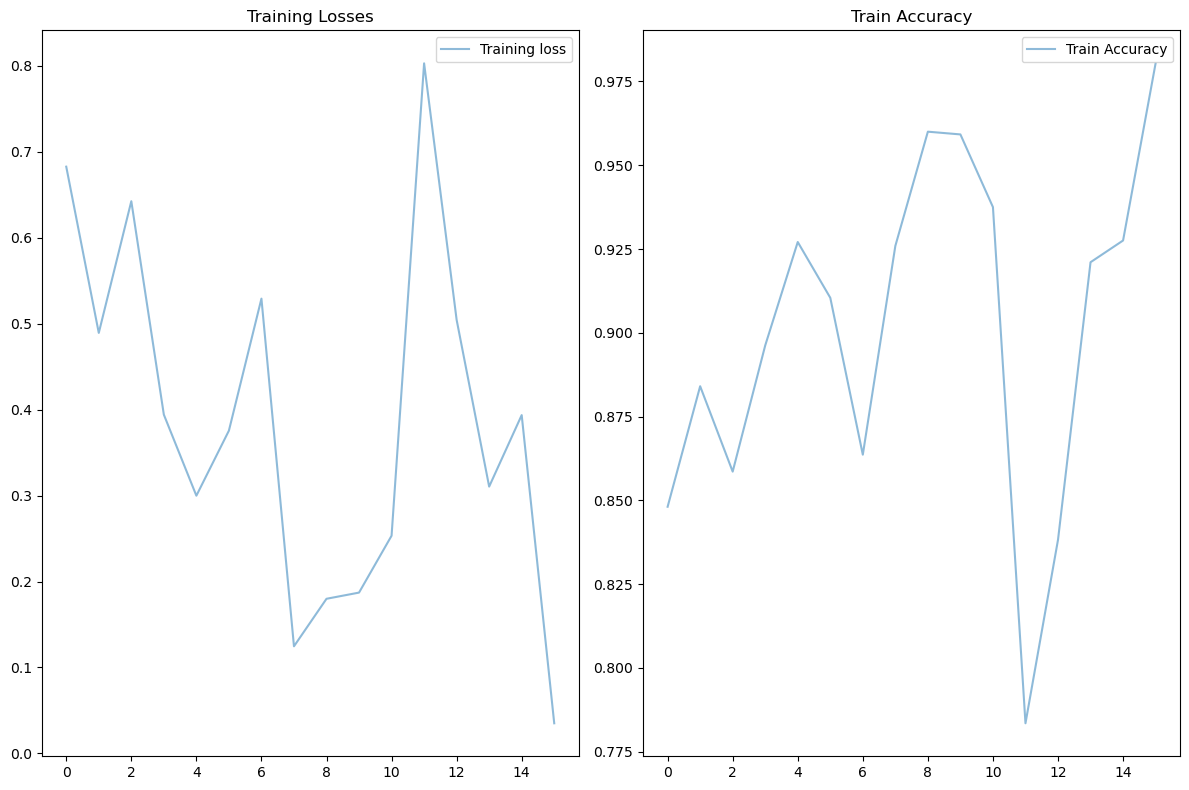

In [111]:
# Ensure plots render in Jupyter
%matplotlib inline

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Plot training loss on the first axis
ax1.plot(metrics_df['train_loss'], label='Training loss', alpha=0.5)
ax1.set_title('Training Losses')
ax1.legend()

# Plot training accuracy on the second axis
ax2.plot(metrics_df['train_mean_token_accuracy'], label='Train Accuracy', alpha=0.5)
ax2.set_title('Train Accuracy')
ax2.legend()

# Display the plots once at the end
plt.tight_layout()
plt.show()

In [125]:
#Calculate Results using perplexity
full_valid_loss = 0.677292  # value found in metrics_df 

# Calculate perplexity
perplexity_openai = math.exp(full_valid_loss)

# Print the result
print("Perplexity:", perplexity_openai)

Perplexity: 1.9685397022862101


In [121]:
# Append loss and perplexity to the results all list 
results_list_all.append({"Metric": "Training Loss OpenAI", "Value": metrics_df['full_valid_loss'].iloc[1]})
results_list_all.append({"Metric": "Perplexity OpenAI", "Value": round(perplexity_openai, 4)})
results_list_all

[{'Metric': 'Training Loss CB data Trained T5', 'Value': 1.3792},
 {'Metric': 'Perplexity CB data Trained T5', 'Value': 3.9718},
 {'Metric': 'Training Loss CB Fine-Tuned T5', 'Value': 0.7204},
 {'Metric': 'Perplexity CB Fine-Tuned T5', 'Value': 2.0552},
 {'Metric': 'Training Loss OpenAI', 'Value': 0.6772924593867465},
 {'Metric': 'Perplexity OpenAI', 'Value': 1.9685}]

### Chat with OpenAI API Trained Model

In [113]:
def chat_with_my_model(user_request):
    try:
        response = client.chat.completions.create(
            model = 'ft:gpt-3.5-turbo-0125:personal:crunchbase-data:9xczAAsN',
            messages=[
                {"role": "user", "content": user_request}
            ]
        )

        chat_response = response.choices[0].message.content

        return chat_response

    except Exception as e:
        return str(e)

In [114]:
user_message = "Please provide a summary of Citi Bank."

response = chat_with_my_model(user_message)

print(response)

Citi Bank was founded in 2014 and is based in New York. It focuses on Citi is a financial services company that offers a range of financial products and services, including consumer banking, and credit cards..


In [115]:
user_message = "Tell me about Talkspace."

response = chat_with_my_model(user_message)

print(response)

Talkspace was founded in 2014 and is based in New York. It focuses on Talkspace is a digital behavioral health company..


# Comparison of All Models 

In [124]:
model_names = ['CB Data Trained T5', 'CB Fine-Tuned T5', ' CB Fine-Tuned OpenAI']
training_loss = [1.3792, 0.7204, 0.6772924593867465]
perplexity = [3.9718, 2.0552, 1.9685]

all_metrics_df = pd.DataFrame({
    'Model Name': model_names,
    'Training Loss': training_loss,
    'Perplexity': perplexity
})
all_metrics_df

,Model Name,Training Loss,Perplexity
0,CB Data Trained T5,1.379200,3.9718
1,CB Fine-Tuned T5,0.720400,2.0552
2,CB Fine-Tuned OpenAI,0.677292,1.9685


## Conclusion
This project involved training a T5 model on Crunchbase data to build knowledge about startups. Afterward, a prompt-completion dataset was generated from this data and used for fine-tuning the model. A Gradio app was created to interact with the model, but the T5 model only responded correctly to exact prompts. To improve performance, the OpenAI GPT-3.5 model was fine-tuned on the same prompt-completion data, yielding the best results with flexible and accurate responses.